In [1]:
using Markdown
using InteractiveUtils
using Statistics
using Graphs, Random, GraphPlot, Plots, Colors, GraphRecipes
using ITensors, ITensorMPS, LinearAlgebra
using JLD2 


In [2]:





function create_MPS(L::Int)
    sites = siteinds("S=1/2", L; conserve_qns=true)
    initial_state = [isodd(i) ? "Up" : "Dn" for i in 1:L]
    ψ₀ = randomMPS(sites, initial_state)
    return ψ₀, sites
end




create_MPS (generic function with 1 method)

In [3]:
"""
Creates a weighted adjacency matrix for a completely connected graph.
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = ones(Float64, N, N)
        A -= Matrix{Float64}(I, N, N)
        return A
    end
    A = zeros(Float64, N, N)
    for i in 1:N, j in (i+1):N
        weight = μ + σ * randn()
        A[i, j] = A[j, i] = weight
    end
    return A
end

create_weighted_adj_mat

In [4]:
"""
Creates the MPO for the XXZ Hamiltonian on a graph with weighted interactions.
"""
function create_weighted_xxz_mpo(N::Int, adj_mat, sites; J::Float64, Δ::Float64)
    ampo = OpSum()
    for i in 1:N-1
        for j in i+1:N
            coupling_strength = adj_mat[i, j]
            if coupling_strength != 0.0
                ampo += coupling_strength * (J / 2), "S+", i, "S-", j
                ampo += coupling_strength * (J / 2), "S-", i, "S+", j
                ampo += coupling_strength * (J * Δ), "Sz", i, "Sz", j
            end
        end
    end
    return MPO(ampo, sites)
end

create_weighted_xxz_mpo

In [5]:

function bond_dim_av_err()
    N_range = 10:1:12
    sigma_values = [0.0, 0.001, 0.002]
    num_graphs_avg = 10
    num_sweeps = 30
    max_bond_dim_limit = 250
    cutoff = 1E-10
    μ = 1.0

    results = Dict(σ => (avg=Float64[], err=Float64[]) for σ in sigma_values)

    for N in N_range
        for σ in sigma_values
            bond_dims_for_avg = Float64[]
            for _ in 1:num_graphs_avg
                ψ₀, sites = create_MPS(N)
                adj_mat = create_weighted_adj_mat(N, σ; μ=μ)
                H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites; J=-0.5, Δ=0.5)

                sweeps = Sweeps(num_sweeps)
                setmaxdim!(sweeps, max_bond_dim_limit)
                setcutoff!(sweeps, cutoff)

                _, ψ_gs = dmrg(H_mpo, ψ₀, sweeps; outputlevel=0)
                push!(bond_dims_for_avg, maxlinkdim(ψ_gs))
            end

            avg_dim = mean(bond_dims_for_avg)
            std_dev = std(bond_dims_for_avg)
            
            push!(results[σ].avg, avg_dim)
            push!(results[σ].err, std_dev)
            println("Completed N = $N, Max Bond Dim = $avg_dim")

        end
    end
    println("...calculations finished.")

    plt = plot(
        title="Saturated Bond Dimension for an Average Graph with N Nodes",
        xlabel="Number of Nodes",
        ylabel="Average Bond Dimension Required",
        legend=:topleft,
        gridalpha=0.3,
        framestyle=:box
    )

    colors = Dict(0.0 => :gold, 0.001 => :darkviolet, 0.002 => :firebrick)

    for σ in sigma_values
        plot!(plt, N_range, results[σ].avg,
            yerror=results[σ].err,
            label="σ = $σ",
            lw=1.5,
            marker=:circle,
            markersize=3,
            color=colors[σ]
        )
    end
    
    return plt, results, N_range
end


bond_dim_av_err (generic function with 1 method)

In [ ]:
plt, results, N_range = bond_dim_av_err();

filename = "avg_err_bd.jld2"
jldsave(filename; results, N_range)
println("Data saved successfully.\n")








In [ ]:
function load_data_and_plot(filename)
    println("Loading data from $filename...")
    if !isfile(filename)
        println("Error: Data file '$filename' not found")
        return nothing
    end
    
    # Load the data from the JLD2 file
    data = load(filename)
    avg_bond_dims = data["results"]
    N_range = data["N_range"]

    N_values = collect(N_range)

    plotlyjs() # Ensure plotting backend is active
    
    colors = Dict(0.0 => :gold, 0.001 => :darkviolet, 0.002 => :firebrick)

    for σ in [0.0, 0.001, 0.002]
        plot!(plt, N_range, results[σ].avg,
            yerror=results[σ].err,
            label="σ = $σ",
            lw=1.5,
            marker=:circle,
            markersize=3,
            color=colors[σ]
        )
    end
    
    return plt
end

load_data_and_plot (generic function with 1 method)

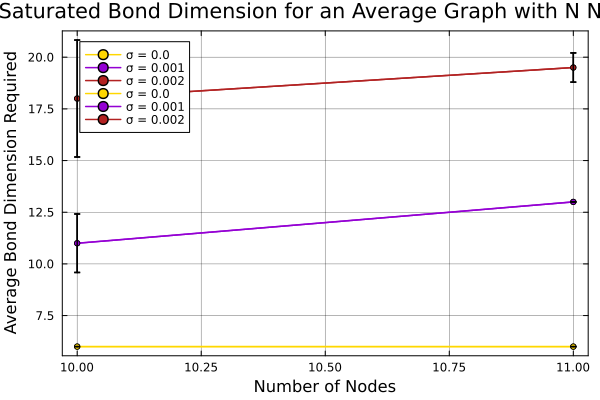

Loading data from avg_err_bond_dim.jld2...


In [ ]:
uplt = load_data_and_plot(filename)
if plt !== nothing
    display(plt)
end